In [1]:
from fastai2.text.all import *

In [2]:
df = pd.read_csv('JEOPARDY_CSV.csv')
print(df.shape); df.head()

(216930, 7)


,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,"No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves",Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,"The city of Yuma in this state has a record average of 4,055 hours of sunshine each year",Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", this company served its billionth burger",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States",John Adams


In [3]:
with open('vocab.pkl', 'rb') as f: vocab = pickle.load(f)

In [4]:
dblock_lm = DataBlock((TextBlock.from_df(' Question', is_lm=True, vocab=vocab),),
                      get_x=ColReader('text'), splitter=RandomSplitter(0.1))
dls_lm = dblock_lm.dataloaders(df, bs=128)

In [21]:
with open('vocab.pkl', 'wb') as f: pickle.dump(dls_lm.vocab, f)

In [5]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=.3, metrics=[accuracy, Perplexity()])

In [6]:
learn.load('unfreeze1')

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.05754399299621582)

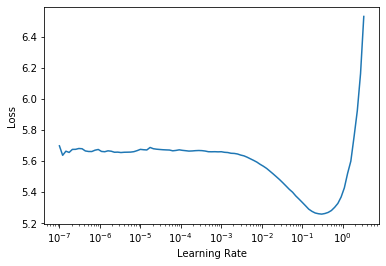

In [7]:
learn.lr_find()

In [19]:
moms = (.8,.7,.8)

In [17]:
learn.fit_one_cycle(1, 3e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.799754,3.604700,0.387883,36.770664,08:18


In [18]:
learn.save('freeze1')

In [19]:
learn.load('freeze1')

In [24]:
learn.unfreeze()
learn.fit_one_cycle(1, 3e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.323877,3.350289,0.425025,28.510975,09:04


In [25]:
learn.save('unfreeze1')

In [26]:
learn.load('unfreeze1')

In [7]:
learn.save_encoder('enc')

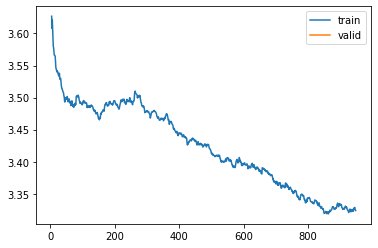

In [27]:
learn.recorder.plot_loss()

## Classifier

TODO: Create dls with low level datasets, why is 'Question' necessary?

In [8]:
df_orig = df
df = df[df[' Value'] != 'None'].copy()

In [9]:
df[' Value'] = df[' Value'].apply(lambda o: int(o[1:].replace(',','')))

In [10]:
vs = np.array(df[' Value'])
bins = np.arange(vs.min(), vs.max(), 500)
df[' Value'] = bins[np.digitize(vs, bins)-1]

In [11]:
dblock_cls = DataBlock((TextBlock.from_df(' Question', vocab=dls_lm.vocab), CategoryBlock(vocab=bins)),
                        get_x=ColReader('text'), get_y=ColReader(' Value'),
                        splitter=RandomSplitter(.1))
dls_cls = dblock_cls.dataloaders(df)

In [13]:
dls_cls.show_batch(max_n=1)

,text,category
0,"xxbos ( < a href=""http : / / xxrep 3 w .j - archive.com / media / 2009 - 01 - 05_dj_01b.jpg "" target=""_blank"">jon of the xxmaj clue xxmaj crew stands with some bronze busts of inductees at the xxmaj pro xxmaj football xxmaj hall of xxmaj fame in xxmaj canton , xxup oh . < / a > ) < a href=""http : / / xxrep 3 w .j - archive.com / media / 2009 - 01 - 05_dj_01.jpg "" xxunk xxmaj xxunk < / a > , < a href=""http : / / xxrep 3 w .j - archive.com / media / 2009 - 01 - xxunk "" xxunk xxmaj csonka < / a > , < a href=""http : / / xxrep 3 w .j - archive.com / media / 2009 - 01 - 05_dj_01b.jpg "" xxunk xxmaj griese < / a > , < a href=""http",5


Before all, what's the accuracy if we only predict the most common token?

In [31]:
Counter(df[' Value']).most_common(1)[0][1] / len(df)

0.46614563798664765

In [15]:
learn = text_classifier_learner(dls_cls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [17]:
learn.load_encoder('enc')

In [20]:
learn.fit_one_cycle(1, 3e-2, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.265733,1.218886,0.468330,01:41


In [21]:
def get_lrs(lr): return slice(lr/(2.6**4),lr)

In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, get_lrs(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.195631,1.206677,0.475925,01:57


In [33]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, get_lrs(5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.173652,1.430619,0.478410,02:48


In [34]:
learn.unfreeze()
learn.fit_one_cycle(2, get_lrs(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.158866,1.280763,0.475362,04:03
1,1.128580,1.271938,0.475831,04:07


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(7, get_lrs(1e-3))

epoch,train_loss,valid_loss,accuracy,time


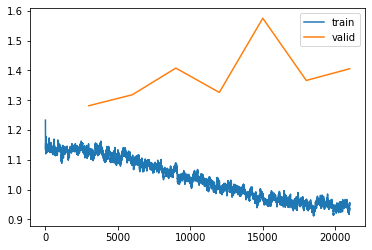

In [37]:
learn.recorder.plot_loss()

In [38]:
learn.validate()

(#2) [1.4057896137237549,0.45510807633399963]